In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
df_train = pd.read_csv("train.csv")
df_val = pd.read_csv("val.csv")
df_test = pd.read_csv("test.csv")

y_train = df_train['label'].tolist()
y_val = df_val['label'].tolist()
y_test = df_test['label'].tolist()

In [4]:
def load_w2v_embedding(idx, folder_path):
    emb = np.load(f"{folder_path}/embedding_{idx}.npy")
    mask = np.load(f"{folder_path}/mask_{idx}.npy")
    return torch.tensor(emb, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

In [5]:
def create_batch(indices, folder_path, labels):
    embeddings, masks, batch_labels = [], [], []
    for idx in indices:
        emb, mask = load_w2v_embedding(idx, folder_path)
        embeddings.append(emb)
        masks.append(mask)
        batch_labels.append(labels[idx])

    embeddings = torch.stack(embeddings).to(device)
    masks = torch.stack(masks).to(device)
    batch_labels = torch.tensor(batch_labels).to(device)
    return embeddings, masks, batch_labels

In [6]:
embedding_dim = 100
hidden_dim = 256
num_classes = 2

lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
linear = nn.Linear(hidden_dim * 2, num_classes)

lstm = lstm.to(device)
linear = linear.to(device)

In [7]:
def evaluate(lstm, linear, folder_path, labels, batch_size=32):
    lstm.eval()
    linear.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for i in range(0, len(labels), batch_size):
            batch_idx = list(range(i, min(i+batch_size, len(labels))))
            embeddings, masks, lbls = create_batch(batch_idx, folder_path, labels)
            outputs, _ = lstm(embeddings)
            lengths = masks.sum(dim=1) - 1
            last_outputs = outputs[torch.arange(outputs.size(0)), lengths.long()]
            logits = linear(last_outputs)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(lbls.cpu())
    y_pred = torch.cat(all_preds)
    y_true = torch.cat(all_labels)
    acc = (y_pred == y_true).float().mean().item()
    return y_pred, y_true, acc


In [8]:
history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'test_acc': []}
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(lstm.parameters()) + list(linear.parameters()), lr=1e-4)
num_epochs = 5
batch_size = 32

train_folder = "train_w2v_embeddings"
val_folder = "val_w2v_embeddings"
test_folder = "test_w2v_embeddings"

for epoch in range(num_epochs):
    lstm.train()
    linear.train()
    total_loss = 0
    all_preds, all_labels = [], []

    indices = list(range(len(y_train)))
    np.random.shuffle(indices)

    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        embeddings, masks, labels = create_batch(batch_indices, train_folder, y_train)

        optimizer.zero_grad()
        outputs, _ = lstm(embeddings)
        lengths = masks.sum(dim=1) - 1
        last_outputs = outputs[torch.arange(outputs.size(0)), lengths.long()]
        logits = linear(last_outputs)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    train_acc = (torch.cat(all_preds) == torch.cat(all_labels)).float().mean().item()
    _, _, val_acc = evaluate(lstm, linear, val_folder, y_val, batch_size=batch_size)
    _, _, test_acc = evaluate(lstm, linear, test_folder, y_test, batch_size=batch_size)

    history['train_loss'].append(total_loss / (len(indices) / batch_size))
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['test_acc'].append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {history['train_loss'][-1]:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")


Epoch 1/5 | Loss: 0.3715 | Train Acc: 0.8299 | Val Acc: 0.8713 | Test Acc: 0.8711
Epoch 2/5 | Loss: 0.2897 | Train Acc: 0.8749 | Val Acc: 0.9086 | Test Acc: 0.9080
Epoch 3/5 | Loss: 0.2463 | Train Acc: 0.9034 | Val Acc: 0.9067 | Test Acc: 0.9073
Epoch 4/5 | Loss: 0.2452 | Train Acc: 0.9056 | Val Acc: 0.9183 | Test Acc: 0.9171
Epoch 5/5 | Loss: 0.2333 | Train Acc: 0.9071 | Val Acc: 0.9286 | Test Acc: 0.9282


In [9]:
pd.DataFrame(history).to_csv("w2v_lstm_batch32_history.csv", index=False)

In [10]:
y_pred, y_true, _ = evaluate(lstm, linear, test_folder, y_test, batch_size=batch_size)
print("\nClassification Report (Test Set):")
print(classification_report(y_true, y_pred, digits=4))


Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.9259    0.9470    0.9363      6883
           1     0.9313    0.9046    0.9178      5471

    accuracy                         0.9282     12354
   macro avg     0.9286    0.9258    0.9270     12354
weighted avg     0.9283    0.9282    0.9281     12354



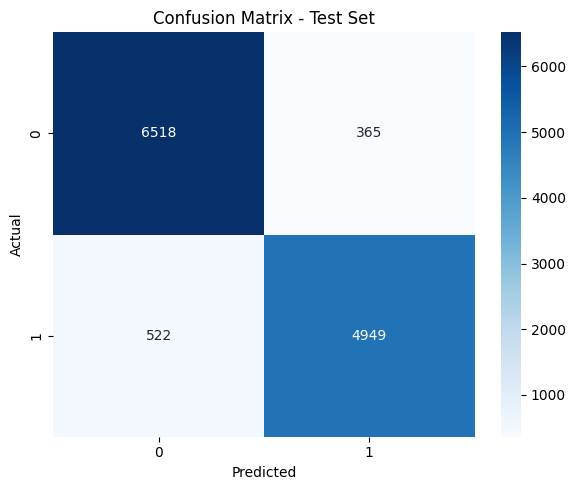

In [11]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()

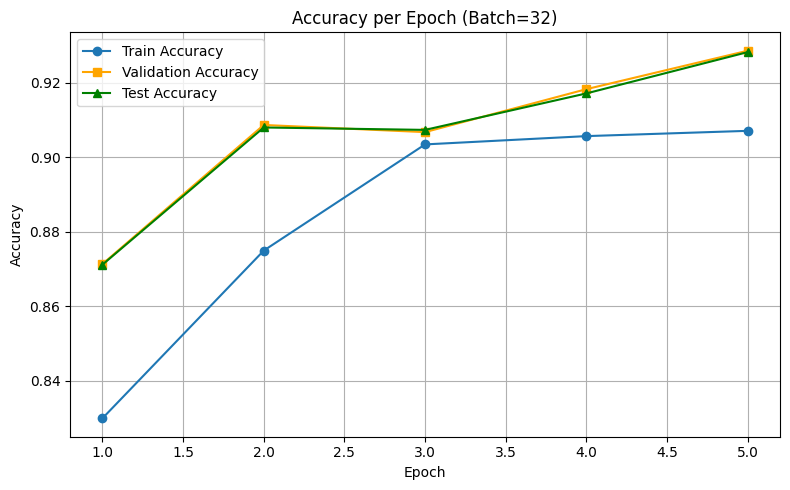

In [12]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy', marker='s', color='orange')
plt.plot(epochs, history['test_acc'], label='Test Accuracy', marker='^', color='green')
plt.title('Accuracy per Epoch (Batch=32)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()

In [13]:
torch.save(lstm.state_dict(), "w2v_lstm_batch32_model.pt")
torch.save(linear.state_dict(), "w2v_lstm_batch32_linear.pt")